In [1]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


## Plot settings
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=14)
plt.rc('animation', html='jshtml')
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
## Read coordinates and indices

grid_coordinates = []
with open('../../Grids/AB_grid.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(',')
        point = (float(elements[0]),float(elements[1]))
        grid_coordinates.append(point)
        line = reader.readline()

jump_coordinates = []
with open('../../Grids/AB_jump_coordinates.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            temp = ele.replace('(', '').replace(')', '')
            if temp != 'stop':
                x = temp.split(',')[0]
                y = temp.split(',')[1]
                point = (float(x),float(y))
                data_block.append(point)
            else:
                break
        line = reader.readline()
        jump_coordinates.append(data_block)

jump_indices = []
with open('../../Grids/AB_jump_indices.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            if ele != 'stop':
                data_block.append(int(ele))
            else:
                break
        line = reader.readline()
        jump_indices.append(data_block)

bott_indices = []
with open('AB_Bott_indices.txt', 'r') as reader:
    line = reader.readline()
    
    while line != '':
        ele = line.replace('(', '').replace(')', '')
        elements = ele.split(',')
        package = (float(elements[0]), int(elements[1]))
        line = reader.readline()
        bott_indices.append(package)

# For drawing vertices use grid_coordinates
# For drawing lines use jump_coordinates
# For indices use jump_indices

## We now want to scale down the plot so it will fit inside a unit square in the 1st quadrant

# Compare x and y components seperatly to for the maximal distances along each axis
xs = [x for x,y in grid_coordinates]
ys = [y for x,y in grid_coordinates]

xs_length = abs(max(xs)) + abs(min(xs))
ys_length = abs(max(ys)) + abs(min(ys))

# We can now scale all xs and ys to fit inside a unit square
xs_scaled = [i/xs_length for i in xs]
ys_scaled = [i/ys_length for i in ys]
grid_scaled = [(x,y) for x, y in zip(xs_scaled, ys_scaled)]

# Same thing for all jump coodinates
jump_scaled = []
for i in jump_coordinates:
    xs_temp = [j[0]/xs_length for j in i]
    ys_temp = [j[1]/ys_length for j in i]
    jump_temp = [(x,y) for x, y in zip(xs_temp, ys_temp)]
    jump_scaled.append(jump_temp)


# The new vertices are stored in grid_scaled
# The new jumps are stored in jump_scaled

## IMPORTANT WE WILL USE THE GRID SCALED FOR ROTATIONS THIS MAKES THE WORK EASIER ##

## DEFINITION OF USEFUL FUNCTIONS

# We now change the Hamiltonian to be rotationally symmetric a thus we change the Peierls phase
# Calculation in notes
# Everything else is identical to the other rotation script
def Hamil_solve(z, w, B):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(z)
    H = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = [x for x in range(0, dim_H)]
    # Calculate Peierls phase factor according to the 1st artcle 
    
    # Start by finding the tile length
    tile_lens = [np.linalg.norm(np.array(z[0]) - np.array(x)) for x in w[0]]
    tile_lens_sum = np.sum(tile_lens)
    l  = tile_lens_sum/len(tile_lens)
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(z, w):
        products = [(i[0]*k[1] - k[0]*i[1]) for k in j]
        jump_products.append(products)
    phase_factors = []
    for i, j in zip(z, jump_products):
        phases = [-(phi/(2 * l**2)) * k for k in j]
        phase_factors.append(phases)

    # Scaling via J, maybe energy factor
    J = 1
    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_indices, phase_factors):
        for k, t in zip(y, z):
            H[x, k] = -J * np.exp(1j * t)

    # Now we find the eigenvalues and eigenvectors
    # Note that eigh returns normalized eigenvectors!
    # Note the eigenvectors are arranged in a matrix so eig_vecs[:,i] chooses the i'th column which is the i'th eigenvector
    eig_vals, U = np.linalg.eigh(H)
    eig_vecs = np.array([U[:,i] for i in range(len(U))])
    return eig_vals, eig_vecs

def Hamil_solve_perturb(z, w, B):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(z)
    H0 = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = np.arange(0, dim_H)
    # Calculate Peierls phase factor according to the 1st artcle 
    
    # Scaling via J, maybe energy factor
    J = 1

    # Start by finding the tile length
    tile_lens = [np.linalg.norm(np.array(z[0]) - np.array(x)) for x in w[0]]
    tile_lens_sum = np.sum(tile_lens)
    l  = tile_lens_sum/len(tile_lens)
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(z, w):
        products = [(i[0]*k[1] - k[0]*i[1]) for k in j]
        jump_products.append(products)
    terms_by_sites = []
    for i, j in zip(z, jump_products):
        phases = [-(phi/(2 * l**2)) * k for k in j]
        terms = [-J * np.exp(1j * t) for t in phases]
        terms_by_sites.append(terms)

    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_indices, terms_by_sites):
        for k, t in zip(y, z):
            H0[x][k] = t

    # Add the diagonal perturbation
    perturbs_temp = np.random.normal(0, 0.6*(1/5), dim_H)
    perturbs = [abs(x) for x in perturbs_temp]
    H_prime = np.diag(perturbs)

    # This is the new hamiltonian we will solve, just as previously
    H = H0 + H_prime

    eig_vals, U = np.linalg.eigh(H)
    eig_vecs = np.array([U[:,i] for i in range(len(U))])
    
    return eig_vals, eig_vecs

# Read the phases in
evec_phases = []
with open('../../Separate_files/AB_args.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        ele = line.strip('\n')
        val = float(ele)
        evec_phases.append(val)
        line = reader.readline()

phases_ind = [(ele, count) for count, ele in enumerate(evec_phases)]

# Time evolution by giving index of states
def time_evolve_evec(group_of_states, time, evec, eval):

    hbar = 1
    t = time

    # Make the group of states in to vectors and multiply with time op
    phis = [np.exp(1j*(eval[i]/hbar)*t)*evec[i] for i in group_of_states]

    # Make a linear combination equally divided
    a = len(phis)
    psi = sum([(1/a)*x for x in phis])

    phi_norm = psi / (np.sqrt(np.vdot(psi,psi)))

    density_of_states = [(x.conj() * x).real for x in phi_norm]
    
    return phi_norm, density_of_states


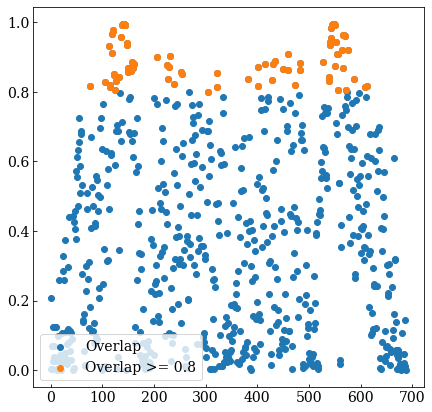

In [3]:
# phi in this case is phi = B*l*2 so B must be equal to
B_full = (2*np.pi)/(0.03825242185233838**2)

unper_evals, unper_evecs = Hamil_solve(grid_scaled, jump_scaled, (0.25)*B_full)
per_evals, per_evecs = Hamil_solve_perturb(grid_scaled, jump_scaled, (0.25)*B_full)

# Now we can check the overlap of eigenvectors
# Firstly checking only those of similar index
overlaps = [(np.vdot(x,y) * np.vdot(x,y).conj()).real for x,y in zip(unper_evecs, per_evecs)]

overlaps_high = [(x,count) for count, x in enumerate(overlaps) if x >= 0.8]

fig, ax = plt.subplots(figsize= (7,7))

xs = range(len(unper_evecs))

ax.scatter(x= xs, y= overlaps, label = 'Overlap')


xs_high = [x for y,x in overlaps_high]
ys_high = [y for y,x in overlaps_high]
ax.scatter(x= xs_high, y= ys_high, label = 'Overlap >= 0.8')

ax.legend(loc= 3)
plt.show()